In [3]:
import random
import os
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean

from mrcnn.config import Config
from mrcnn import utils
from mrcnn.utils import extract_bboxes
from mrcnn.utils import compute_ap
from mrcnn.utils import Dataset

from mrcnn import visualize
from mrcnn.visualize import display_instances
from mrcnn.visualize import display_images

import mrcnn.model as modellib
from mrcnn.model import MaskRCNN
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.model import log

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline 

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [4]:
# Load table dataset
class TableDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, subset):
        # define one class
        self.add_class("table", 1, "table")
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]

            imgage_path = images_dir + filename
            anno_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('table', image_id=image_id, path=imgage_path, annotation=anno_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # Parse the xml file
        tree = ElementTree.parse(filename)
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coordinates = [xmin, ymin, xmax, ymax]
            boxes.append(coordinates)
        # extract image dimensions 
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
       
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('table'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
# load the train dataset
train_set = TableDataset()
train_set.load_dataset('table', "train")
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# load the test dataset
test_set = TableDataset()
test_set.load_dataset('table', "val")
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 492
Test: 123


In [5]:
# define the prediction configuration
class TableConfig(Config):
    # define the name of the configuration
    NAME = "table_cfg"
    # number of classes (background + table)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 500
    IMAGE_MAX_DIM = 1024
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.5
    #IMAGE_MAX_DIM = 512

# create config
config = TableConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Load and Train the model
### Iteration 1

In [16]:
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (trained on mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

W0623 10:42:47.330067 140342746093376 module_wrapper.py:139] From /mnt/disks/user/project/Mask_RCNN/mrcnn/model.py:553: The name tf.random_shuffle is deprecated. Please use tf.random.shuffle instead.



In [17]:
# train weights (output layers or 'heads') for 5 epochs
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./table_cfg20200623T1042/mask_rcnn_table_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeD

W0623 10:43:18.496267 140342746093376 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse Indexed

Epoch 1/5
500/500 [==============================] - 649s 1s/step - loss: 1.4837 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.6077 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.4913 - mrcnn_mask_loss: 0.2489 - val_loss: 1.3150 - val_rpn_class_loss: 0.0251 - val_rpn_bbox_loss: 0.5881 - val_mrcnn_class_loss: 0.0791 - val_mrcnn_bbox_loss: 0.4059 - val_mrcnn_mask_loss: 0.2168


W0623 10:54:14.728476 140342746093376 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:1265: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.



Epoch 2/5
500/500 [==============================] - 599s 1s/step - loss: 0.8334 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3721 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.2147 - mrcnn_mask_loss: 0.1688 - val_loss: 1.0416 - val_rpn_class_loss: 0.0213 - val_rpn_bbox_loss: 0.5227 - val_mrcnn_class_loss: 0.0622 - val_mrcnn_bbox_loss: 0.2256 - val_mrcnn_mask_loss: 0.2098
Epoch 3/5
485/500 [============================>.] - ETA: 17s - loss: 0.7964 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3776 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.1816 - mrcnn_mask_loss: 0.1670

E0623 11:14:47.939891 140339914458880 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

486/500 [============================>.] - ETA: 15s - loss: 0.7970 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3778 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.1818 - mrcnn_mask_loss: 0.1671

E0623 11:14:49.053314 140339914458880 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

487/500 [============================>.] - ETA: 14s - loss: 0.7959 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3772 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.1816 - mrcnn_mask_loss: 0.1669

E0623 11:14:50.164120 140339914458880 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

496/500 [============================>.] - ETA: 4s - loss: 0.7926 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3752 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.1810 - mrcnn_mask_loss: 0.1667

E0623 11:15:00.345017 140339914458880 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

500/500 [==============================] - 600s 1s/step - loss: 0.7961 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3796 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.1805 - mrcnn_mask_loss: 0.1665 - val_loss: 0.9733 - val_rpn_class_loss: 0.0089 - val_rpn_bbox_loss: 0.5535 - val_mrcnn_class_loss: 0.0583 - val_mrcnn_bbox_loss: 0.1820 - val_mrcnn_mask_loss: 0.1706
Epoch 4/5
497/500 [============================>.] - ETA: 3s - loss: 0.7735 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3933 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.1558

E0623 11:24:59.532863 140339914458880 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

498/500 [============================>.] - ETA: 2s - loss: 0.7733 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3930 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.1559

E0623 11:25:00.658472 140339914458880 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

499/500 [============================>.] - ETA: 1s - loss: 0.7724 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3924 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.1558

E0623 11:25:01.780096 140339914458880 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

500/500 [==============================] - 597s 1s/step - loss: 0.7715 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3918 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.1557 - val_loss: 0.7101 - val_rpn_class_loss: 0.0072 - val_rpn_bbox_loss: 0.4132 - val_mrcnn_class_loss: 0.0470 - val_mrcnn_bbox_loss: 0.1460 - val_mrcnn_mask_loss: 0.0966
Epoch 5/5
  8/500 [..............................] - ETA: 9:17 - loss: 0.7112 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.2816 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.1652 - mrcnn_mask_loss: 0.1579

E0623 11:25:43.123867 140339914458880 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

500/500 [==============================] - 597s 1s/step - loss: 0.6931 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3655 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.1163 - mrcnn_mask_loss: 0.1418 - val_loss: 1.0077 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.6266 - val_mrcnn_class_loss: 0.0654 - val_mrcnn_bbox_loss: 0.1549 - val_mrcnn_mask_loss: 0.1523


In [8]:
model = MaskRCNN(mode='training', model_dir='./', config=config)
model.load_weights('mask_rcnn_table_cfg_0005.h5', by_name=True)

In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers.
model.train(train_set, test_set, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: ./table_cfg20200622T1239/mask_rcnn_table_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Batc

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/engine/training_gen

Epoch 1/10
173/500 [=========>....................] - ETA: 12:34 - loss: 0.6422 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.3139 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.1351

E0622 12:47:05.359157 140665300223744 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

179/500 [=========>....................] - ETA: 12:15 - loss: 0.6378 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.3135 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.1174 - mrcnn_mask_loss: 0.1332

E0622 12:47:16.490837 140665300223744 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

184/500 [==========>...................] - ETA: 12:00 - loss: 0.6378 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.3160 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.1167 - mrcnn_mask_loss: 0.1319

E0622 12:47:25.742311 140665300223744 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

186/500 [==========>...................] - ETA: 11:54 - loss: 0.6387 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3179 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.1166 - mrcnn_mask_loss: 0.1314

E0622 12:47:29.458482 140665300223744 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

500/500 [==============================] - 1042s 2s/step - loss: 0.5725 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2765 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.1227 - val_loss: 0.6282 - val_rpn_class_loss: 0.0061 - val_rpn_bbox_loss: 0.3478 - val_mrcnn_class_loss: 0.0450 - val_mrcnn_bbox_loss: 0.1049 - val_mrcnn_mask_loss: 0.1244
Epoch 2/10
500/500 [==============================] - 961s 2s/step - loss: 0.4296 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1767 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0808 - mrcnn_mask_loss: 0.1220 - val_loss: 0.6382 - val_rpn_class_loss: 0.0287 - val_rpn_bbox_loss: 0.2690 - val_mrcnn_class_loss: 0.0634 - val_mrcnn_bbox_loss: 0.1293 - val_mrcnn_mask_loss: 0.1478
Epoch 3/10
500/500 [==============================] - 962s 2s/step - loss: 0.3650 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1124 - val_loss: 0.3367 - val_rpn_class_loss: 0.005

E0622 14:16:50.456977 140665300223744 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

383/500 [=====================>........] - ETA: 3:36 - loss: 0.2208 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.0912

E0622 14:17:01.604187 140665300223744 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

388/500 [======================>.......] - ETA: 3:27 - loss: 0.2198 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.0907

E0622 14:17:10.861172 140665300223744 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

390/500 [======================>.......] - ETA: 3:23 - loss: 0.2197 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0673 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.0906

E0622 14:17:14.592437 140665300223744 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

500/500 [==============================] - 958s 2s/step - loss: 0.2298 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.0927 - val_loss: 0.2953 - val_rpn_class_loss: 0.0013 - val_rpn_bbox_loss: 0.0907 - val_mrcnn_class_loss: 0.0272 - val_mrcnn_bbox_loss: 0.0474 - val_mrcnn_mask_loss: 0.1286
Epoch 7/10
500/500 [==============================] - 958s 2s/step - loss: 0.2473 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0376 - mrcnn_mask_loss: 0.0932 - val_loss: 0.5814 - val_rpn_class_loss: 0.0049 - val_rpn_bbox_loss: 0.1853 - val_mrcnn_class_loss: 0.0593 - val_mrcnn_bbox_loss: 0.1253 - val_mrcnn_mask_loss: 0.2065
Epoch 8/10
500/500 [==============================] - 957s 2s/step - loss: 0.2532 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.1067 - val_loss: 0.2237 - val_rpn_class_loss: 0.0031

E0622 15:15:40.958713 140665300223744 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

219/500 [============>.................] - ETA: 8:39 - loss: 0.1345 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0345 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0184 - mrcnn_mask_loss: 0.0678

E0622 15:15:52.087825 140665300223744 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

224/500 [============>.................] - ETA: 8:30 - loss: 0.1372 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0356 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0186 - mrcnn_mask_loss: 0.0691

E0622 15:16:01.342850 140665300223744 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

226/500 [============>.................] - ETA: 8:27 - loss: 0.1371 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0355 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0186 - mrcnn_mask_loss: 0.0691

E0622 15:16:05.070216 140665300223744 model.py:1810] Error processing image {'id': '.ipynb_checkpo', 'source': 'table', 'path': 'table/train/images/.ipynb_checkpoints', 'annotation': 'table/train/annots/.ipynb_checkpo.xml'}
Traceback (most recent call last):
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "/mnt/disks/user/project/Mask_RCNN/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/mnt/dis

500/500 [==============================] - 957s 2s/step - loss: 0.1637 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0807 - val_loss: 0.2823 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 0.1411 - val_mrcnn_class_loss: 0.0219 - val_mrcnn_bbox_loss: 0.0330 - val_mrcnn_mask_loss: 0.0846


### Iteration 2

In [7]:
model = MaskRCNN(mode='training', model_dir='./', config=config)
model.load_weights('mask_rcnn_table_cfg_0010.h5', by_name=True)
model.train(train_set, test_set, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10, 
            layers="all")

W0625 07:06:17.335431 140548669466432 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 07:06:17.449414 140548669466432 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 07:06:17.475868 140548669466432 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 07:06:17.595722 140548669466432 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2139: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm i

500/500 [==============================] - 953s 2s/step - loss: 0.1620 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0802 - val_loss: 0.3958 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.1109 - val_mrcnn_class_loss: 0.0365 - val_mrcnn_bbox_loss: 0.0695 - val_mrcnn_mask_loss: 0.1773
Epoch 3/10
500/500 [==============================] - 951s 2s/step - loss: 0.1629 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0780 - val_loss: 0.2018 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 0.0864 - val_mrcnn_class_loss: 0.0136 - val_mrcnn_bbox_loss: 0.0212 - val_mrcnn_mask_loss: 0.0788
Epoch 4/10
500/500 [==============================] - 944s 2s/step - loss: 0.1805 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0885 - val_loss: 0.2648 - val_rpn_class_loss: 0.0035

In [6]:
class_names = ['BG','table']
# define the prediction configuration 
class TestConfig(Config):
    NAME = "test"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    DETECTION_MIN_CONFIDENCE = 0.9
    #DETECTION_NMS_THRESHOLD = 0.5 

In [8]:
# # create config for inference or prediction
# tst_conf=TestConfig()
# # define the model
# rcnn = MaskRCNN(mode='inference', model_dir='./', config=tst_conf)
# # load coco model weights
# rcnn.load_weights('mask_rcnn_table_cfg_0019.h5', by_name=True)


W0525 05:44:20.002547 140055750203200 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0525 05:44:20.136161 140055750203200 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0525 05:44:20.159110 140055750203200 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0525 05:44:20.301458 140055750203200 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2139: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm i

In [7]:
# create config for inference or prediction
tst_conf=TestConfig()
# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=tst_conf)
# load coco model weights
rcnn.load_weights('mask_rcnn_table_cfg_0010.h5', by_name=True)

W0624 05:04:09.715019 140574254794560 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 05:04:09.849662 140574254794560 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 05:04:09.876062 140574254794560 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 05:04:10.012822 140574254794560 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2139: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm i

In [23]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        #print(image_id)
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

In [26]:
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, rcnn, tst_conf)
print("Train mAP: %.3f" % train_mAP)

Train mAP: 0.964


In [11]:
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, rcnn, tst_conf)
print("Test mAP: %.3f" % test_mAP)

Test mAP: 0.906


### Evaluation for Iteration 2

In [ ]:
# create config for inference or prediction
tst_conf=TestConfig()
# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=tst_conf)
# load coco model weights
rcnn.load_weights('mask_rcnn_table_cfg_0035.h5', by_name=True)

In [ ]:
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, rcnn, tst_conf)
print("Train mAP: %.3f" % train_mAP)

In [ ]:
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, rcnn, tst_conf)
print("Test mAP: %.3f" % test_mAP)

## Visualizing Results on random Images of test set¶

In [8]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

image ID: table.us-020-page3 (35) table/val/images/us-020-page3.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  114.00000  max:  841.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


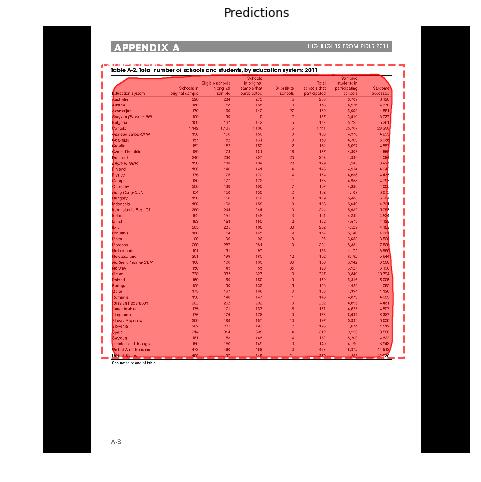

In [9]:
#Run detections
image_id = random.choice(test_set.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =   modellib.load_image_gt(test_set, config, image_id, use_mini_mask=False)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, test_set.image_reference(image_id)))
# Run object detection
results = rcnn.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], test_set.class_names, r['scores'], ax=ax,
                                                                                                        title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

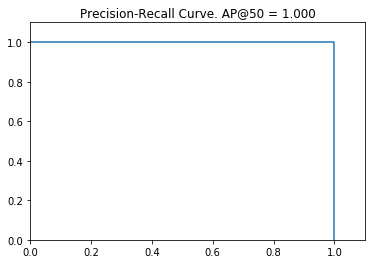

In [11]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps =compute_ap(gt_bbox, gt_class_id, gt_mask,r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

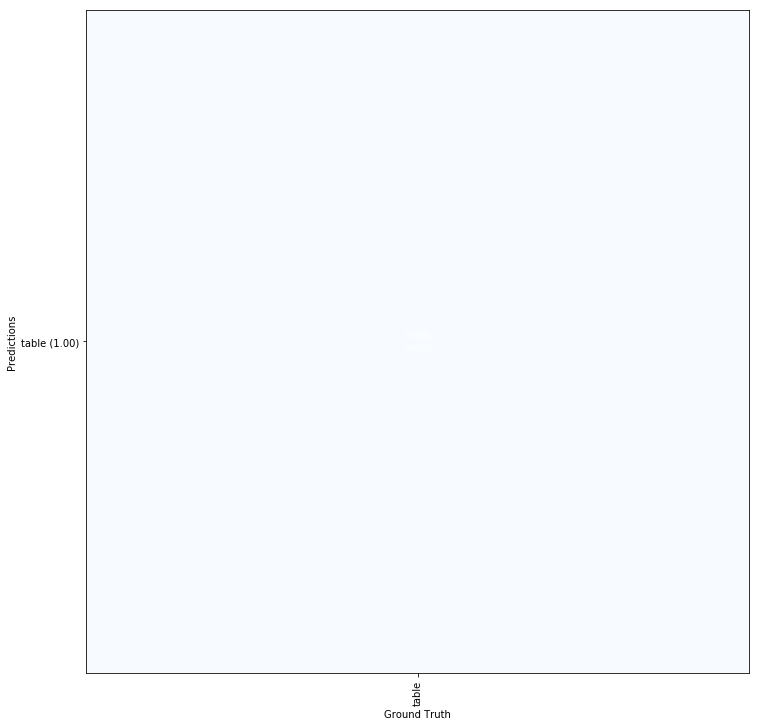

In [12]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'], overlaps, test_set.class_names)

In [13]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(test_set, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = rcnn.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(test_set.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  1.0


### Visualizing Results and dimensions on another random Image of test set

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


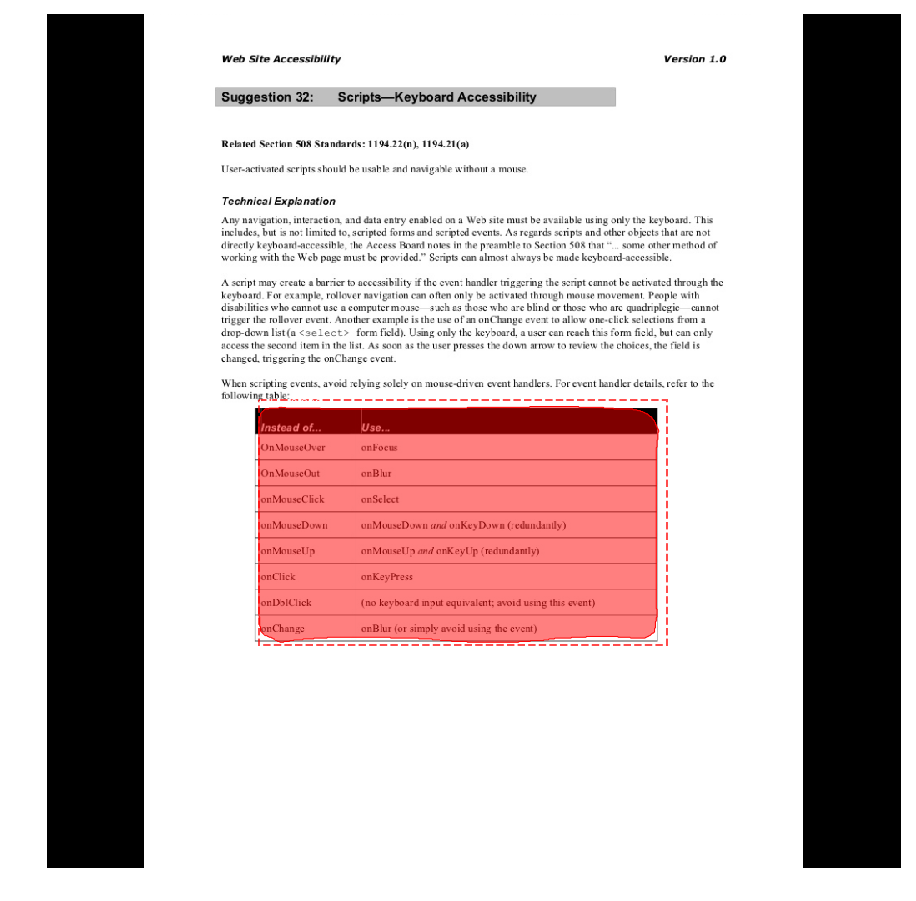

In [14]:
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =  modellib.load_image_gt(test_set, tst_conf, 
                                                                                               image_id, use_mini_mask=False)
results=rcnn.detect([original_image],verbose=1)
r = results[0]
display_instances(original_image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [65]:
#image = test_set.load_image(image_id)

#r = results[0]
#print(r)
#print(r['masks'])
#print(r['masks'].shape[-1])
#print(class_names)
#print(scores[0])
#boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]
# show photo with bounding boxes, masks, class labels and scores

#display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

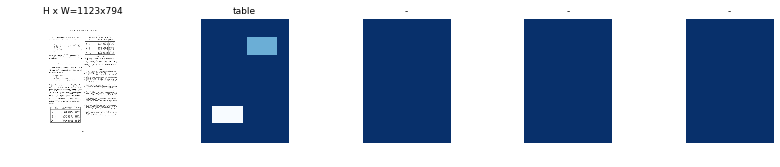

[[165 412 324 683]
 [788  98 943 378]]


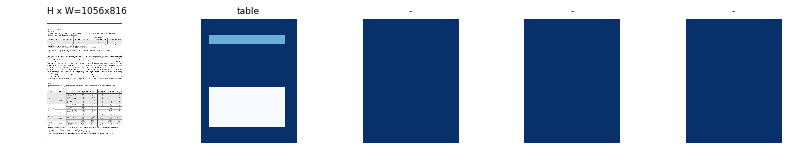

[[140  67 215 716]
 [583  67 917 716]]


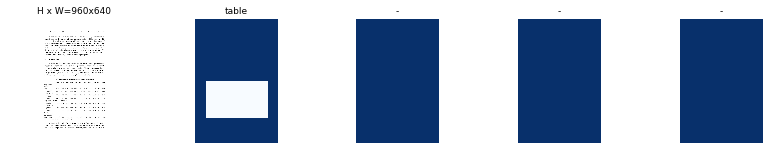

[[478  81 768 562]]


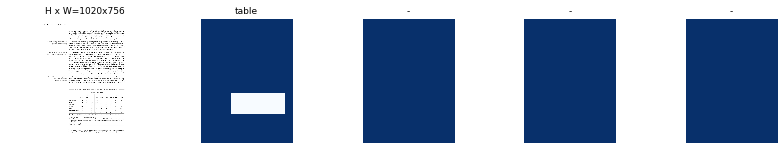

[[610 246 781 694]]


In [15]:
# Load and display random samples
image_ids = np.random.choice(test_set.image_ids, 4)
for image_id in image_ids:
    image = test_set.load_image(image_id)
    mask, class_ids = test_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, test_set.class_names)
    bbox = utils.extract_bboxes(mask)
    print(bbox)

### Check dimensions and GT mask of original test image

image_id  1 table/val/images/10.1.1.185.1562_87.jpg
image                    shape: (915, 643, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (915, 643, 1)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   59.00000  max:  582.00000  int32


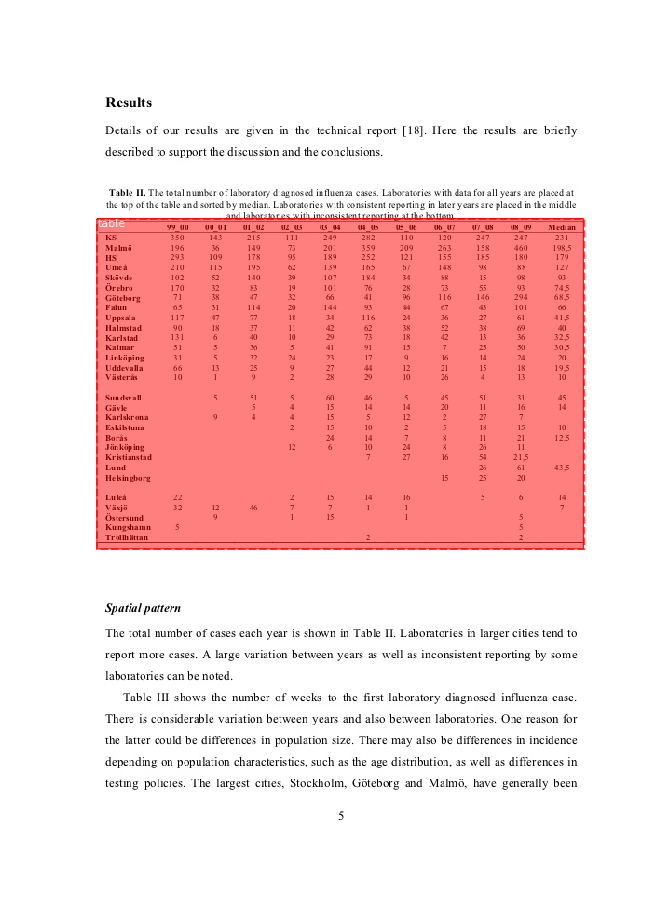

In [16]:
# Load random image and mask.
#image_id = random.choice(test_set.image_ids)
image_id=1
image = test_set.load_image(image_id)
mask, class_ids = test_set.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, test_set.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, test_set.class_names)

In [17]:
#test_set.image_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122])

In [ ]:
#train_set.image_ids

In [12]:
#image_id=45

### Check dimensions and GT mask of Resized image 

image_id:  52 table/val/images/10.1.1.185.1558_41.jpg
Original shape:  (1056, 816, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  115.00000  max:  908.00000  int32


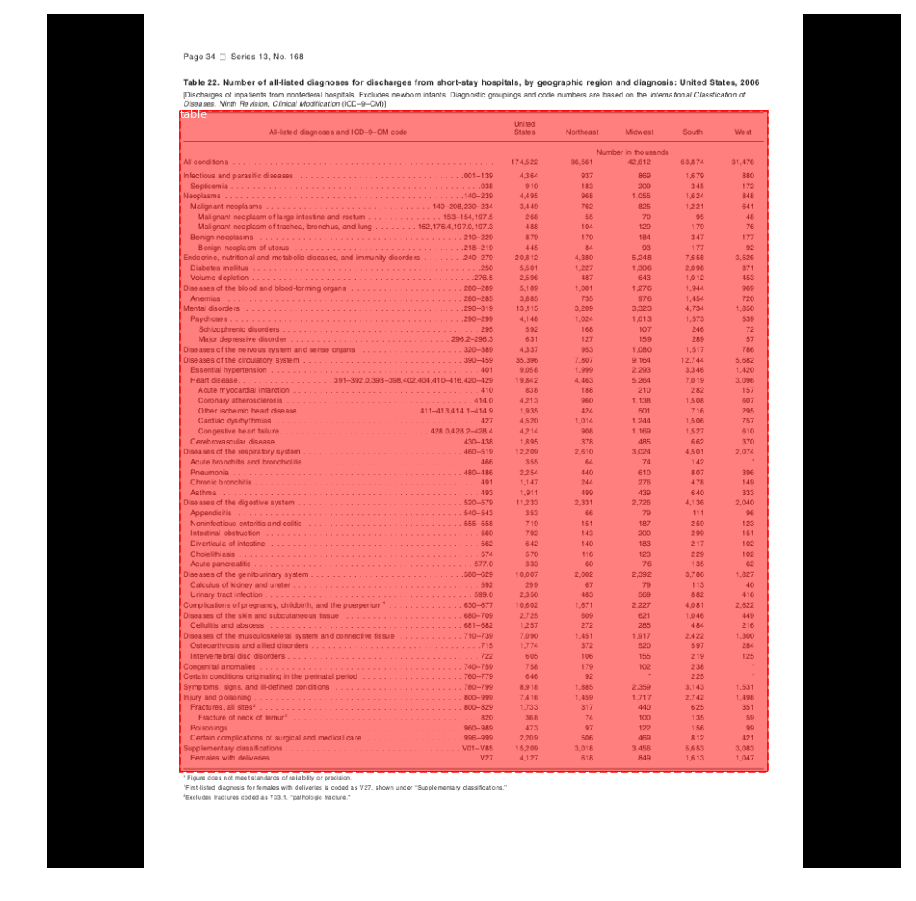

In [13]:
# Load random image and mask.
image_id = np.random.choice(test_set.image_ids, 1)[0]
#image_id = image_id[0]
image = test_set.load_image(image_id)
mask, class_ids = test_set.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, test_set.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, test_set.class_names)

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  218.00000  max:  804.00000  int32
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


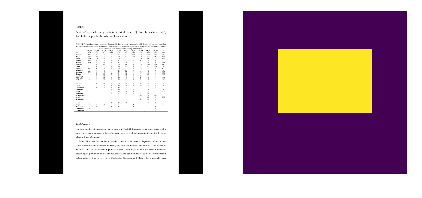

In [18]:
#image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    test_set, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

W0624 05:09:56.620439 140574254794560 model.py:1225] 'augment' is deprecated. Use 'augmentation' instead.


mask                     shape: (56, 56, 1)           min:    1.00000  max:    1.00000  bool
1
[]


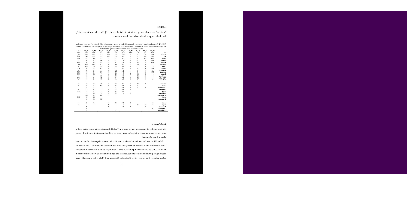

In [19]:
# Add augmentation and mask resizing. augmentation=imgaug.augmenters.Fliplr(0.5)
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(test_set, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
print(mask.shape[2])
print(mask[56:57,:,0])
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])


## Visualizing Anchors and related parameters

In [20]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)
print("backbone_shapes:",backbone_shapes)
# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))
print(image_id)

backbone_shapes: [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768
1


backbone_shapes [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
Level 0. Anchors: 196608  Feature map Shape: [256 256]
[128 128] 32896
center_anchor 98688.0 128
Level 1. Anchors:  49152  Feature map Shape: [128 128]
[64 64] 8256
center_anchor 24768.0 64
Level 2. Anchors:  12288  Feature map Shape: [64 64]
[32 32] 2080
center_anchor 6240.0 32
Level 3. Anchors:   3072  Feature map Shape: [32 32]
[16 16] 528
center_anchor 1584.0 16
Level 4. Anchors:    768  Feature map Shape: [16 16]
[8 8] 136
center_anchor 408.0 8


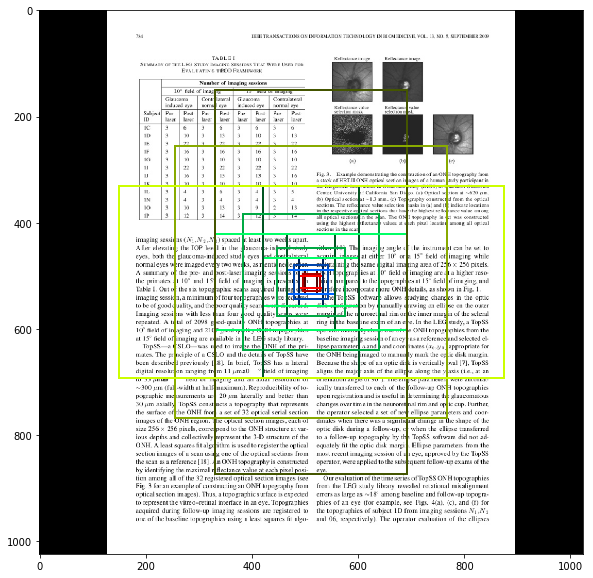

In [21]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(test_set.image_ids, 1)[0]
#image_id=45
image, image_meta, _, _, _ = modellib.load_image_gt(test_set, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)
print("backbone_shapes",backbone_shapes)
for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    print(center_cell, center_cell_index)
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)
    print("center_anchor",center_anchor, center_cell[0])
    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


In [22]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    test_set, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)


In [23]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
#image_id=45
print("image_id: ", image_id, test_set.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]
print(len(rois))
#print(image_meta)

rois                     shape: (4, 200, 4)           min:    2.00000  max: 1022.00000  int32
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 200, 2, 4)        min:   -4.04221  max:    3.38951  float32
mrcnn_mask               shape: (4, 200, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  844.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -1.69871  max:    1.91505  float64
image_id:  117 table/val/images/10.1.1.193.1818_3.jpg
4


anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (6, 4)                min:  192.00000  max:  822.00000  float32
Positive anchors: 6
Negative anchors: 250
Neutral anchors: 261632
image_id:  117 table/val/images/10.1.1.193.1818_3.jpg
BG                     : 173
table                  : 27


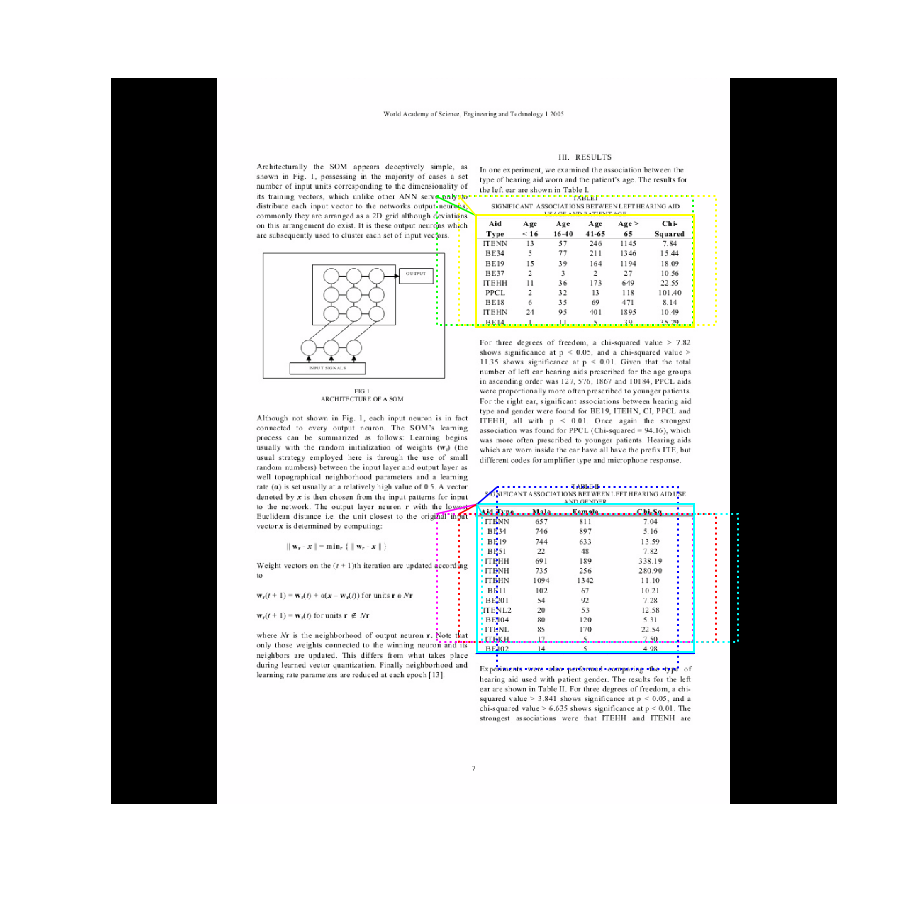

In [24]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, test_set.image_reference(image_id))

# ROI breakdown by class
for c, n in zip(test_set.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)


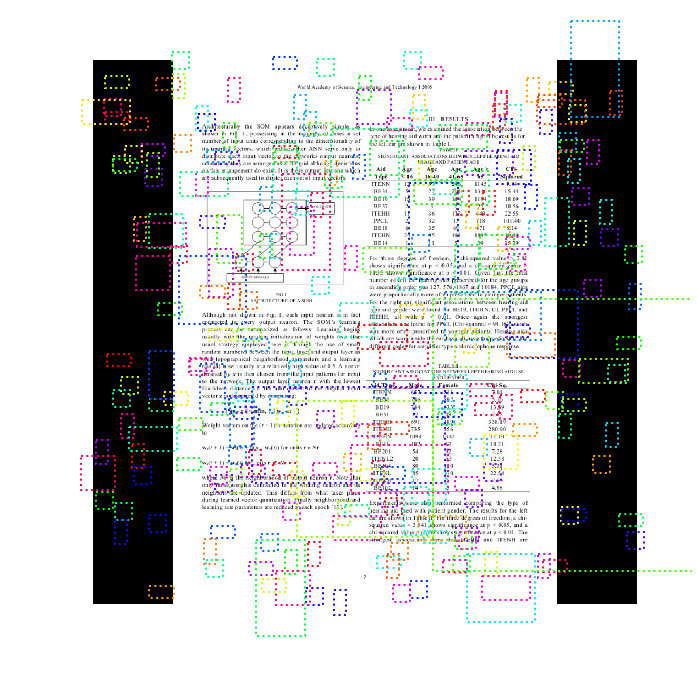

In [25]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

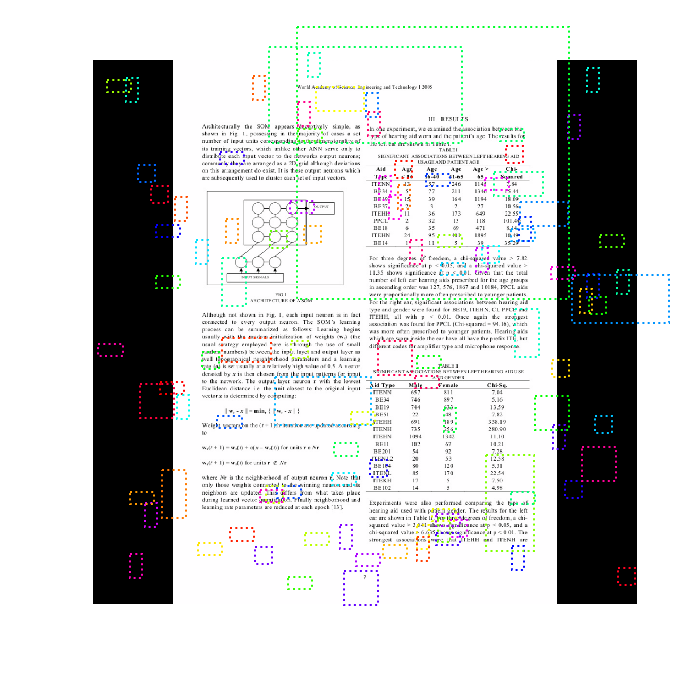

In [26]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

Positive ROIs:  27
Negative ROIs:  173
Positive Ratio: 0.14
Unique ROIs: 200 out of 200


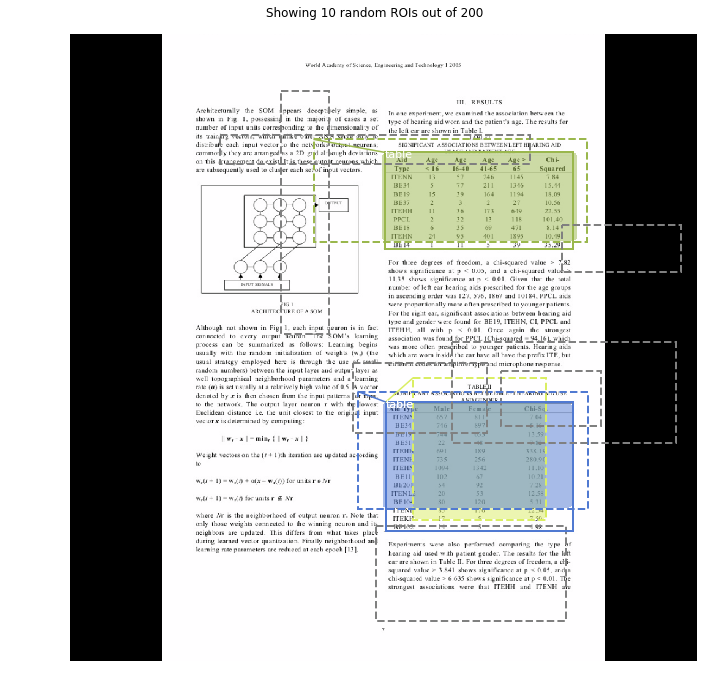

In [27]:
#ROIs

if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], test_set.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

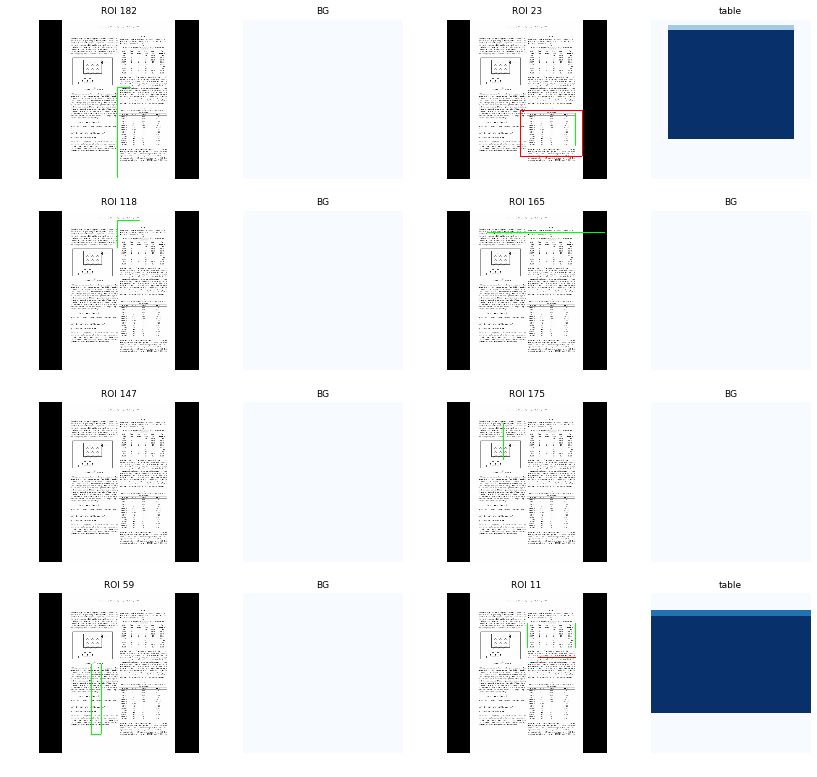

In [28]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(test_set.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [29]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        test_set, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1123.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  115.00000  max:  819.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


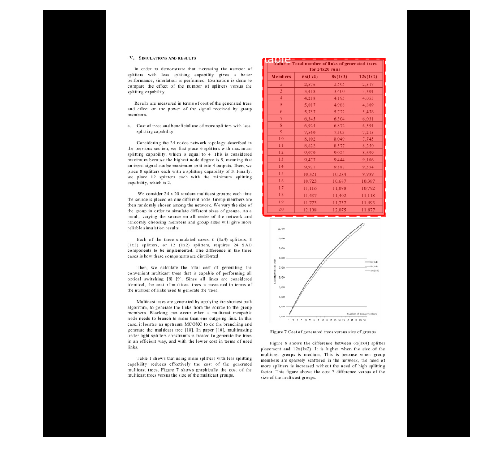

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


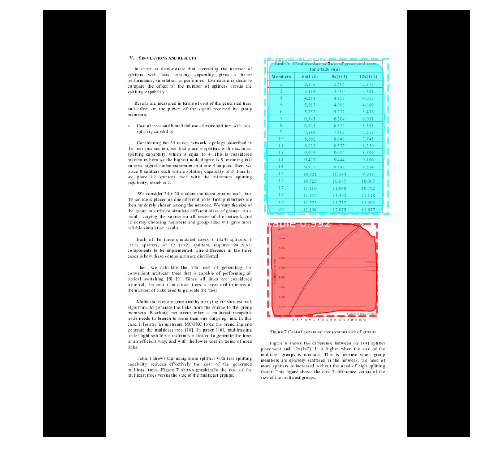

In [30]:
#First, show the ground truth of the image, then show detection results.
image_id=45
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(test_set, tst_conf, 
                                                                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_set.class_names, figsize=(8, 8))

results = rcnn.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            train_set.class_names, r['scores'], ax=get_ax())

image ID: table.10.1.1.193.1812_24 (61) table/val/images/10.1.1.193.1812_24.jpg


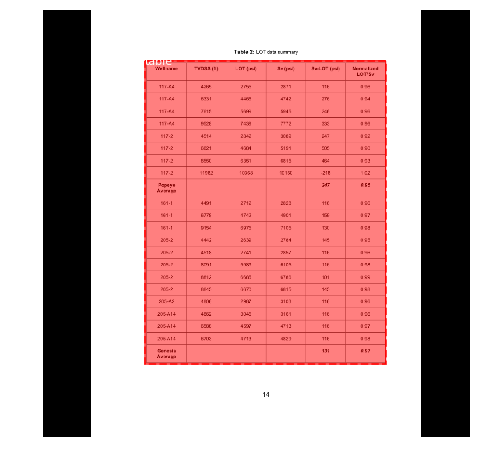

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  120.00000  max:  848.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


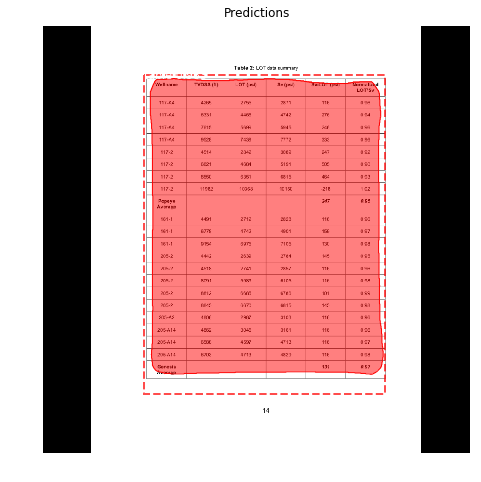

In [51]:
#ground truth vs detection in test set
image_id = random.choice(test_set.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, TestConfig, image_id, use_mini_mask=False)


info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       test_set.image_reference(image_id)))
visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            test_set.class_names, figsize=(8, 8))

# Run object detection
results = rcnn.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [31]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, rcnn.anchors, gt_class_id, gt_bbox, rcnn.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = rcnn.anchors[positive_anchor_ix]
negative_anchors = rcnn.anchors[negative_anchor_ix]
neutral_anchors = rcnn.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * rcnn.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -1.91406  max:    1.92206  float64
positive_anchors         shape: (4, 4)                min:  128.00000  max:  800.00000  float64
negative_anchors         shape: (252, 4)              min:  -29.25483  max: 1194.03867  float64
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (4, 4)                min:  115.00000  max:  819.00000  float32


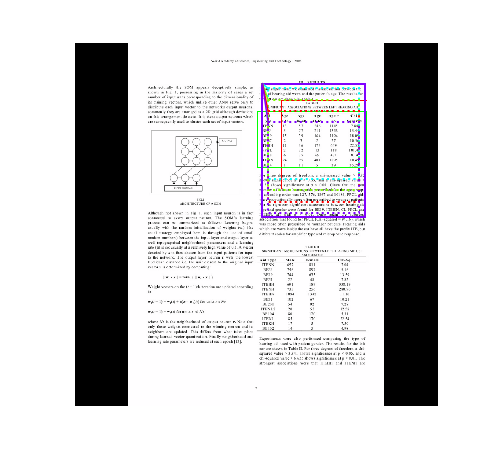

In [32]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

In [33]:
# Run RPN sub-graph
pillar = rcnn.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = rcnn.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = rcnn.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = rcnn.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = rcnn.run_graph([image], [
    ("rpn_class", rcnn.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", rcnn.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", rcnn.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", rcnn.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", rcnn.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35390  max:    1.29134  float32
refined_anchors          shape: (1, 6000, 4)          min:  -87.54388  max:   88.80016  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (746,)                min:    0.00000  max: 5987.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


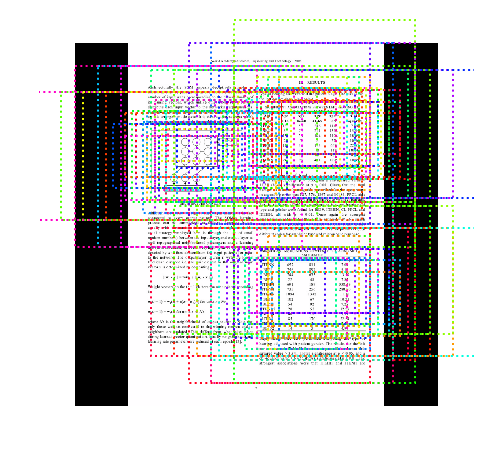

In [34]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=rcnn.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

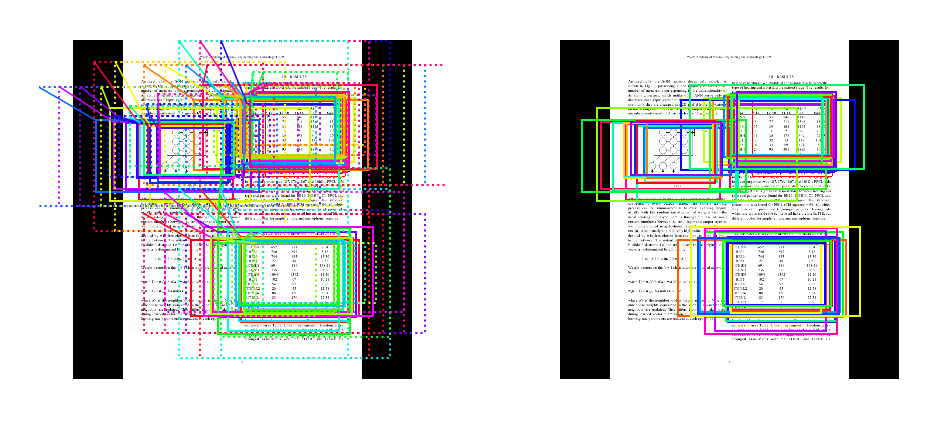

In [35]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
#print(rpn)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

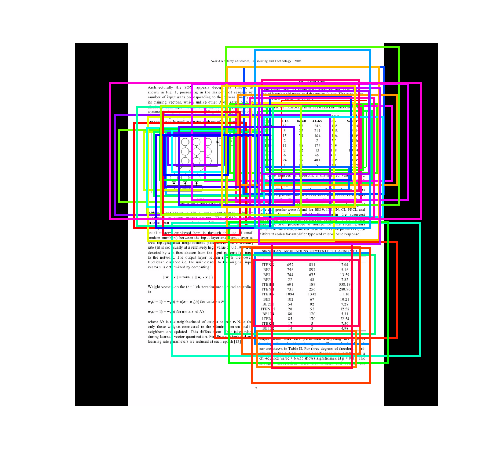

In [36]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

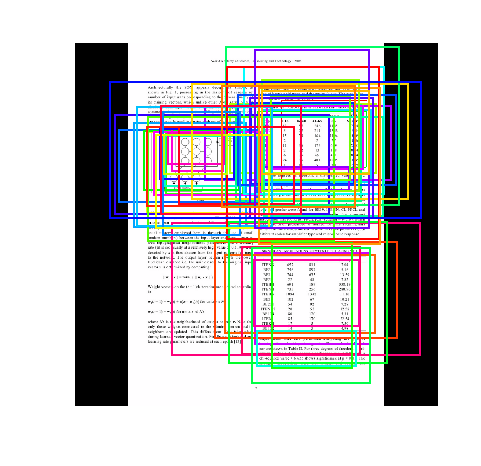

In [37]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [38]:
# Get input and output to classifier and mask heads.
mrcnn = rcnn.run_graph([image], [
    ("proposals", rcnn.keras_model.get_layer("ROI").output),
    ("probs", rcnn.keras_model.get_layer("mrcnn_class").output),
    ("deltas", rcnn.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", rcnn.keras_model.get_layer("mrcnn_mask").output),
    ("detections", rcnn.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -4.34039  max:    4.55118  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


In [46]:
mrcnn

OrderedDict([('proposals',
              array([[[0.03755372, 0.18558437, 0.09994432, 0.26715797],
                      [0.2556065 , 0.22259837, 0.5344595 , 0.8119771 ],
                      [0.3156084 , 0.3041123 , 0.48278165, 0.71236014],
                      ...,
                      [0.20408568, 0.49887183, 0.7270287 , 1.        ],
                      [0.07622892, 0.5783347 , 0.18476349, 0.8062288 ],
                      [0.9492666 , 0.48955336, 0.95592505, 0.5003253 ]]], dtype=float32)),
             ('probs', array([[[8.7954402e-03, 9.9120456e-01],
                      [1.0646393e-02, 9.8935366e-01],
                      [2.2978125e-02, 9.7702187e-01],
                      ...,
                      [9.9668199e-01, 3.3180064e-03],
                      [9.9992144e-01, 7.8572200e-05],
                      [9.9996793e-01, 3.2091397e-05]]], dtype=float32)),
             ('deltas',
              array([[[[-0.06043881,  0.62949544,  0.97803116, -0.12739784],
               

3 detections: ['table' 'table' 'table']


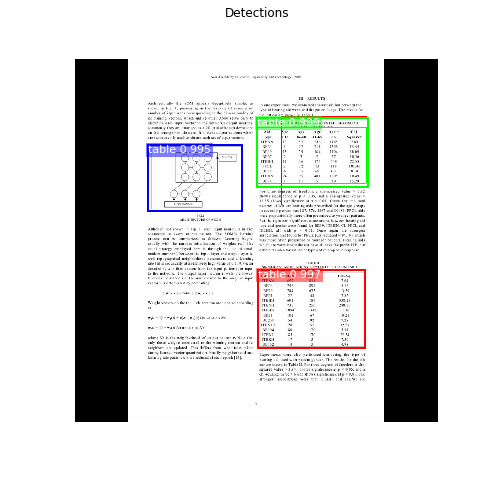

In [39]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(train_set.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(train_set.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

In [40]:
# Step by Step Detection

#Here we dive deeper into the process of processing the detections.

# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(test_set.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

746 Valid proposals out of 1000
43 Positive ROIs
[('BG', 957), ('table', 43)]


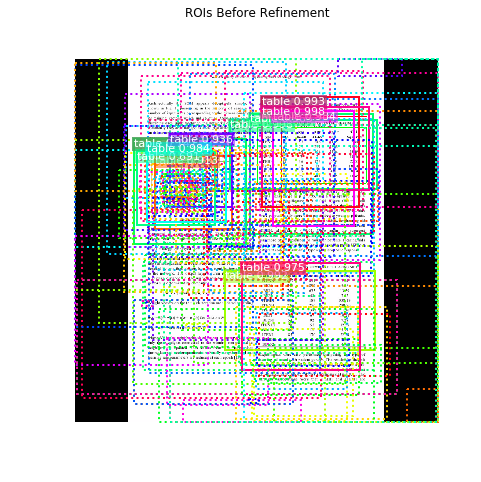

In [41]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(test_set.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

roi_bbox_specific        shape: (1000, 4)             min:   -3.36044  max:    2.44253  float32
refined_proposals        shape: (1000, 4)             min: -184.00000  max: 1172.00000  int32


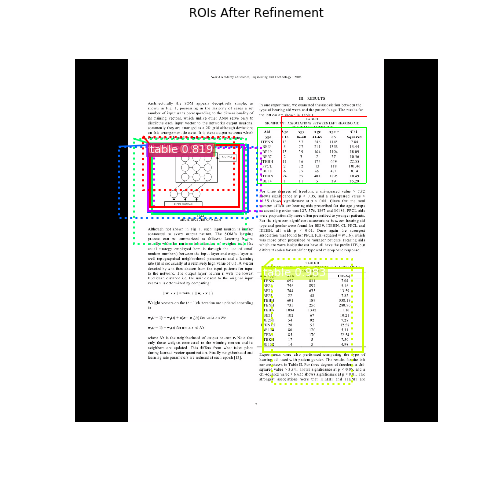

In [42]:
#Apply Bounding Box Refinement
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(test_set.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

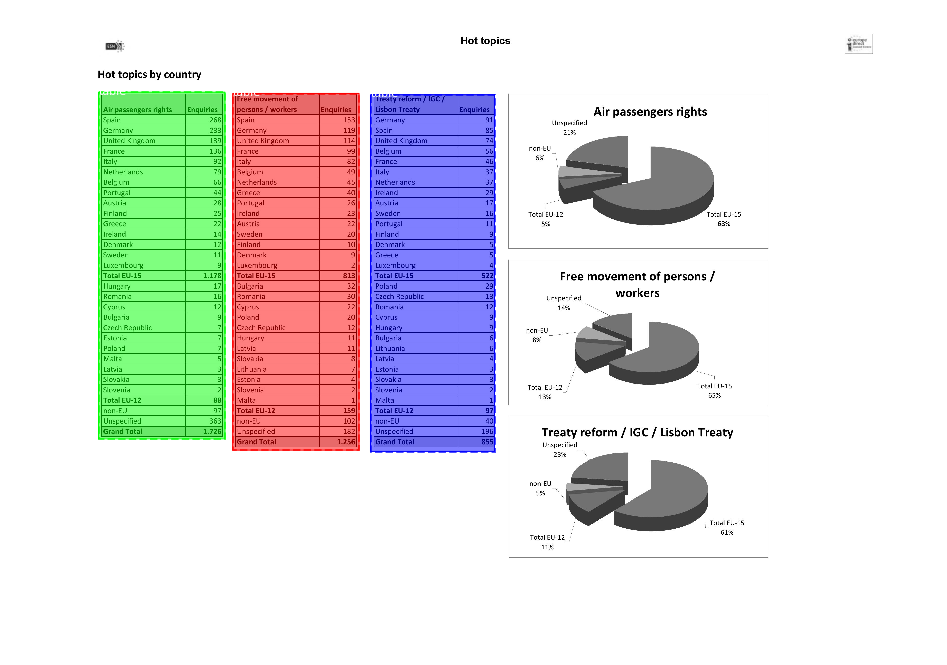

In [43]:
# define image id
image_id = 1
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

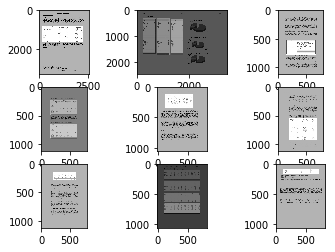

In [44]:
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    image = train_set.load_image(i)
    plt.imshow(image)
    # plot all masks
    mask, _ = train_set.load_mask(i)
    for j in range(mask.shape[2]):
        plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
plt.show()

In [35]:
# # enumerate all images in the dataset
# for image_id in train_set.image_ids:
#     # load image info
#     info = train_set.image_info[image_id]
#     # display on the console
#     print(info)

{'id': 'us-026-page0', 'source': 'table', 'path': 'table/train/images/us-026-page0.jpg', 'annotation': 'table/train/annots/us-026-page0.xml'}
{'id': 'eu-015-page1', 'source': 'table', 'path': 'table/train/images/eu-015-page1.jpg', 'annotation': 'table/train/annots/eu-015-page1.xml'}
{'id': '10.1.1.1.2094_3', 'source': 'table', 'path': 'table/train/images/10.1.1.1.2094_3.jpg', 'annotation': 'table/train/annots/10.1.1.1.2094_3.xml'}
{'id': '10.1.1.6.2248_12', 'source': 'table', 'path': 'table/train/images/10.1.1.6.2248_12.jpg', 'annotation': 'table/train/annots/10.1.1.6.2248_12.xml'}
{'id': '10.1.1.36.5934_16', 'source': 'table', 'path': 'table/train/images/10.1.1.36.5934_16.jpg', 'annotation': 'table/train/annots/10.1.1.36.5934_16.xml'}
{'id': '10.1.1.6.2321_32', 'source': 'table', 'path': 'table/train/images/10.1.1.6.2321_32.jpg', 'annotation': 'table/train/annots/10.1.1.6.2321_32.xml'}
{'id': '10.1.1.6.2340_6', 'source': 'table', 'path': 'table/train/images/10.1.1.6.2340_6.jpg', 'anno

In [45]:
#train_set.image_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [47]:
# class PredictionConfig(Config):
#     # define the name of the configuration
#     NAME = "table_predict_cfg"
#     # number of classes (background + kangaroo)
#     NUM_CLASSES = 1 + 1
#     # simplify GPU config
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1

In [48]:
# # create config
# cfg = PredictionConfig()
# # define the model
# model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# # load model weights
# model.load_weights('mask_rcnn_table_cfg_0010.h5', by_name=True)

In [49]:
#test_set.image_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122])

In [17]:
# # enumerate all images in the dataset
# for image_id in test_set.image_ids:
#     # load image info
#     info = test_set.image_info[image_id]
#     # display on the console
#     print(image_id, info['path'])

0 table/images/eu-015-page1.jpg
1 table/images/eu-007-page4.jpg
2 table/images/eu-004-page11.jpg
3 table/images/eu-021-page6.jpg
4 table/images/eu-018-page0.jpg
5 table/images/eu-006-page1.jpg
6 table/images/eu-004-page9.jpg
7 table/images/eu-014-page1.jpg
8 table/images/eu-005-page1.jpg
9 table/images/eu-012-page2.jpg
10 table/images/eu-022-page1.jpg
11 table/images/eu-026-page3.jpg
12 table/images/eu-025-page2.jpg
13 table/images/eu-007-page2.jpg
14 table/images/eu-019-page2.jpg
15 table/images/eu-006-page0.jpg
16 table/images/eu-027-page2.jpg
17 table/images/eu-008-page0.jpg
18 table/images/eu-004-page10.jpg
19 table/images/eu-002-page0.jpg
20 table/images/eu-004-page1.jpg
21 table/images/eu-009a-page0.jpg
22 table/images/eu-026-page5.jpg
23 table/images/eu-021-page2.jpg
24 table/images/eu-023-page2.jpg
25 table/images/eu-007-page0.jpg
26 table/images/eu-013-page4.jpg
27 table/images/eu-004-page3.jpg
28 table/images/eu-024-page1.jpg
29 table/images/eu-025-page1.jpg
30 table/images/e

In [50]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        #plt.subplot(n_images, 2, i*2+1)
        #plt.subplot(n_images, 2, i*2+1) #subplot(nrows, ncols, index) where index is the position in the grid of output
        f = plt.figure(figsize=(8,8))
        f.add_subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        plt.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Predicted')
        ax = plt.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    plt.show()

In [ ]:
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)

## Test a random image outside train and validation set

In [36]:
# draw an image with detected objects  -- required for testing any random image outside train and val set
def draw_image_with_boxes(filename, boxes_list):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for box in boxes_list:
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    plt.show()

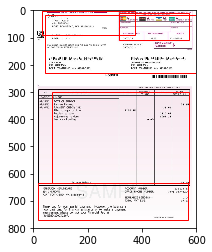

In [38]:
# Test a random photograph to identify a table structure
#img = load_img('image1.jpg')
img = load_img('image1.jpg')
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# visualize the results
draw_image_with_boxes('image1.jpg', results[0]['rois'])